实现暂退法

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

# X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
# print(X)
# print(dropout_layer(X, 0.))
# print(dropout_layer(X, 0.5))
# print(dropout_layer(X, 1.))

定义模型

In [25]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_outputs,
                 num_hiddens1,
                 num_hiddens2,
                 isTraining = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        self.isTraining = isTraining

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        if self.isTraining == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.isTraining == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

定义前置操作

In [26]:
class Animator:
    """用于动画化绘制数据的类"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(4, 3)):
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend if legend is not None else []
        self.fmts = fmts
        self.X = [[] for _ in range(len(self.fmts))]
        self.Y = [[] for _ in range(len(self.fmts))]

        # 设置坐标轴属性
        self.ax.set(xlabel=xlabel, ylabel=ylabel)
        if xlim: self.ax.set_xlim(*xlim)
        if ylim: self.ax.set_ylim(*ylim)
        self.ax.set_xscale(xscale)
        self.ax.set_yscale(yscale)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n

        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        self.ax.clear()
        for xi, yi, fmt in zip(self.X, self.Y, self.fmts):
            self.ax.plot(xi, yi, fmt)

        if self.legend:
            self.ax.legend(self.legend)

        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

class Accumulator:
    def __init__(self, n):
        self.data = [0, 0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0, 0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if y_hat.ndim > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = (y_hat == y)
    return cmp.sum().item()

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(l.sum().item(), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

进行训练

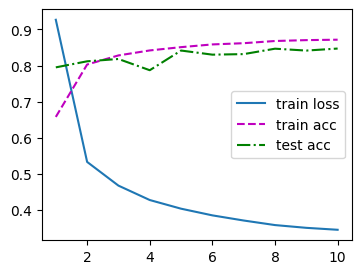

In [27]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

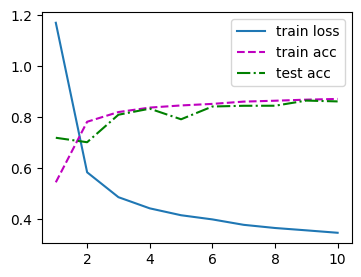

In [31]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens1),
                    nn.ReLU(),
                    nn.Dropout(dropout1),
                    nn.Linear(num_hiddens1, num_hiddens2),
                    nn.ReLU(),
                    nn.Dropout(dropout2),
                    nn.Linear(num_hiddens2, num_outputs))

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)